# Quantum_Magnetometer BNN

In [6]:
# ==== Robust Imports & Env Setup (one cell) ====
from pathlib import Path
import sys, os, time, json, logging, warnings, importlib.util, yaml, platform

import h5py
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow.random import Generator, stateless_uniform
from tensorflow.math import exp, cos, log as tf_log
from tensorflow import ones, cast, dtypes, stop_gradient

import optax
import tqdm
import matplotlib.pyplot as plt

# ---- Make artifacts dir ----
WORK = Path.cwd() / "queso_run_BNN"
WORK.mkdir(parents=True, exist_ok=True)
print("All artifacts will live in →", WORK)

# ---- Add queso-main to PYTHONPATH ----
QUESO_ROOT = Path("/mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-training/queso-main").resolve()
if str(QUESO_ROOT) not in sys.path:
    sys.path.insert(0, str(QUESO_ROOT))

# ---- Quiet TF spam ----
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=r".*retracing")

# ---- QUESO imports ----
from queso.io import IO
from queso.configs import Configuration
from queso.train.train_nn import train_nn

io = IO(folder=str(WORK))

print("TF GPUs:", tf.config.list_physical_devices("GPU"))
print("JAX devices:", jax.devices())

All artifacts will live in → /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN
TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
JAX devices: [CpuDevice(id=0)]


### Create / edit a YAML config inside the notebook

In [7]:

cfg_nn = {
    "seed": 1234, # random seed
    "n_grid": 100, # number of discrete points in the grid of possible ω values
    "nn_dims": [32, 32], #dimensions of the hidden layers of the neural network
    "lr_nn": 1e-3, #learning rate
    "l2_regularization": 0.0,
    "batch_size": 50,
    "n_epochs": 100,
    "n_phis": 100, # number of ω bins to discretize the frequency range over
    "n_shots": 5000,
}
with open(WORK/"config.yaml", "w") as f:
    yaml.safe_dump(cfg_nn, f)

config = Configuration.from_yaml(WORK/"config.yaml")
key    = jax.random.PRNGKey(config.seed)

# --- Physics constants / bounds (TOTAL field) ---
GAMMA_RAD_PER_US_PER_T = 1.760859e5         # electron γ (rad/µs/T)
B_BOUNDS_T = (20e-6, 67e-6)                 # 20–67 µT TOTAL field in Tesla
OMEGA_BOUNDS = (GAMMA_RAD_PER_US_PER_T * B_BOUNDS_T[0],
                GAMMA_RAD_PER_US_PER_T * B_BOUNDS_T[1])  # rad/µs

print(f"{OMEGA_BOUNDS} rad/µs")

(3.5217180000000003, 11.7977553) rad/µs


## Circuit-sampling function

In [8]:
from tensorflow import cast, stop_gradient, ones, expand_dims, Tensor, dtypes
from tensorflow.math import exp, log, cos, abs
from tensorflow.python.ops.ragged.ragged_array_ops import zeros
from tensorflow.random import stateless_uniform, Generator

import time
import os

import h5py
import argparse

import jax
import jax.numpy as jnp

from queso.io import IO
from queso.configs import Configuration
import numpy as np 

def sample_circuit(
    io,                           
    omega_max: float = 10.0,      
    T2: float = 1500.0,           # same unit as τ (here φ is unitless and τ is a scalar)
    F0: float = 0.88,             # readout fidelity for |0>
    F1: float = 0.95,             # readout fidelity for |1>
    n_phis: int = 100,            # NOTE: in the original code this is actually the number of ω bins
    n_shots: int = 5000,
    seed: int = 1234,
):
    """
    Generating data for the BNN.

    - Discretize ω into `n_phis` bins over [0, omega_max] (endpoint=True) in rad/µs**.
    - Use fixed τ = π / ω_max and φ = 0.
    - Single-shot probability with readout fidelity and T2:
        p(0 | ω) = a + b * exp(-τ/T2) * cos(ω * τ + 0),
      where a=(1+F0-F1)/2, b=(F0+F1-1)/2.
    - Save:
        shots: (P, S) in {-1, +1}
        grid : (P,)  == ω grid 
        phis : (P,)  (kept for backward-compat; same as grid)
        probs: (P,1)  theoretical p(0 | ω) for reference (not used by training)
      and HDF5 attrs: tau, F0, F1, T2 for eval/training consistency.
    """
    import jax, jax.numpy as jnp, numpy as np, h5py

    # Discrete ω grid (P bins)
    omega_grid = jnp.linspace(0.0, omega_max, n_phis, endpoint=True, dtype=jnp.float32)  # (P,)
    tau = jnp.pi / float(omega_max)   # fixed τ
    phi0 = 0.0

    # Fidelity parameters
    a = 0.5 * (1.0 + F0 - F1)
    b = 0.5 * (F0 + F1 - 1.0)
    decay = jnp.exp(-tau / float(T2))

    # Theoretical single-shot probability for measuring "0" given ω
    p0_grid = a + b * decay * jnp.cos(omega_grid * tau + phi0)   # (P,)
    p0_grid = jnp.clip(p0_grid, 1e-6, 1.0 - 1e-6)                # numeric safety

    # Sample S shots per ω bin; map {0,1} -> {-1,+1}
    key = jax.random.PRNGKey(int(seed))
    key, kdraw = jax.random.split(key)
    u = jax.random.uniform(kdraw, (n_phis, n_shots), dtype=jnp.float32)  # (P,S)
    outcomes01 = (u < p0_grid[:, None]).astype(jnp.int8)                 # (P,S)
    shots_pm = (2 * outcomes01 - 1).astype(jnp.float32)                  # (P,S)

    # Write H5 (names chosen to keep backward-compat with original code)
    with h5py.File(io.path.joinpath("train_samples.h5"), "w") as hf:
        hf.create_dataset("shots", data=np.array(shots_pm))              # (P,S)
        hf.create_dataset("grid",  data=np.array(omega_grid))            # (P,)
        hf.create_dataset("phis",  data=np.array(omega_grid))            # compat alias
        hf.create_dataset("probs", data=np.array(p0_grid[:, None]))      # (P,1) for reference
        hf.attrs["tau"] = float(tau)
        hf.attrs["F0"]  = float(F0)
        hf.attrs["F1"]  = float(F1)
        hf.attrs["T2"]  = float(T2)
        hf.attrs["omega_units"] = "rad_per_us"

    print(f"[BNN data] Saved {io.path/'train_samples.h5'} "
          f"with ω∈[0,{omega_max}] (P={n_phis}), τ=π/{omega_max}, T2={T2}, F0={F0}, F1={F1}")

In [ ]:
import time
import os
import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import h5py
import argparse
import warnings
import numpy as np 

import jax
import jax.numpy as jnp
import optax

from flax.training import train_state, orbax_utils
from orbax.checkpoint import (
    Checkpointer,

    PyTreeCheckpointHandler,
)

from queso.estimators.flax.dnn import BayesianDNNEstimator
from queso.io import IO
from queso.configs import Configuration
from queso.utils import get_machine_info

def train_nn(
    io,
    config,                   # your Configuration dataclass
    key,                      # jax.random.PRNGKey
    plot: bool = False,
    progress: bool = True,
):
    """
   
    - Treat 'grid' (or fallback 'phis') as the ω grid (classes).
    - Keep per-shot inputs x: shape (P, S, 1) with values in {-1,+1}.
    - Build soft labels q(r|ω) from the physics model with F0/F1/T2 and fixed τ.
    - Optimize soft cross-entropy + L2.
    - Save nn.h5 'grid' and a checkpoint with params and nn_dims, fully compatible with eval().
    """
    import os, time, tqdm, pandas as pd, h5py
    import jax, jax.numpy as jnp
    import optax
    from flax.training import train_state
    from orbax.checkpoint import Checkpointer, PyTreeCheckpointHandler

    # Device selection (same as original)
    jax.config.update("jax_default_device", jax.devices(os.getenv("DEFAULT_DEVICE_TRAIN_NN", "cpu"))[0])

    # NN dimensions and hyper-params
    nn_dims = config.nn_dims + [config.n_grid]
    n_grid = int(config.n_grid)
    lr = float(config.lr_nn)
    l2_regularization = float(config.l2_regularization)
    n_epochs = int(config.n_epochs)
    batch_size = int(config.batch_size)
    from_checkpoint = getattr(config, "from_checkpoint", False)
    logit_norm = False

    t0 = time.time()

    # -------- Load training data --------
    hf = h5py.File(io.path.joinpath("train_samples.h5"), "r")
    shots = jnp.array(hf["shots"])                                   # (P,S) in {-1,+1}
    if "grid" in hf.keys():
        omega_grid = jnp.array(hf["grid"])                           # (P,)
    else:
        omega_grid = jnp.array(hf["phis"])                           # (P,)  (compat)
    tau_attr = hf.attrs.get("tau", None)
    F0 = float(hf.attrs.get("F0", 0.88))
    F1 = float(hf.attrs.get("F1", 0.95))
    T2 = float(hf.attrs.get("T2", 1500.0))                           # your requested default
    hf.close()

    P = int(omega_grid.shape[0])         # number of ω bins (classes)
    S = int(shots.shape[1])              # number of shots per bin

    assert S % batch_size == 0, "batch_size must divide n_shots"
    n_batches = S // batch_size
    n_steps   = n_epochs * n_batches

    # DO NOT rebuild or re-center the grid; use the file's ω grid as-is
    grid = omega_grid  # (B==P,) class centers

    # -------- Build inputs --------
    # Keep per-shot inputs; expand to (P, S, 1)
    x = jnp.expand_dims(shots, axis=-1)   # (P, S, 1)

    # -------- Physics-based soft labels q(r|ω) --------
    # τ from H5 attrs if present, else τ=π/ω_max (ω_max≈grid[-1])
    tau_bnn = float(tau_attr) if (tau_attr is not None) else float(jnp.pi / float(grid[-1]))
    phi0 = 0.0

    a = 0.5 * (1.0 + F0 - F1)
    b = 0.5 * (F0 + F1 - 1.0)
    decay = jnp.exp(-tau_bnn / T2)                                   # scalar

    # p(0 | ω) for each class in the grid
    p0_grid = a + b * decay * jnp.cos(grid * tau_bnn + phi0)         # (B,)
    p0_grid = jnp.clip(p0_grid, 1e-6, 1.0 - 1e-6)

    # Map r∈{-1,+1} to likelihood over classes: q ∝ P(r | ω)
    # If r=+1 (we observed "0"), use p0_grid; else use (1 - p0_grid).
    r_all = jnp.squeeze(x, axis=-1)                                  # (P,S)
    P_lik = jnp.where(r_all[..., None] > 0,                          # broadcast over classes
                      p0_grid[None, None, :],
                      1.0 - p0_grid[None, None, :])                  # (P,S,B)
    q_all = P_lik / jnp.clip(P_lik.sum(axis=-1, keepdims=True), 1e-12, None)  # normalize over classes

    # -------- Model --------
    model = BayesianDNNEstimator(tuple(nn_dims))

    # small dummy for tabulate / shape check
    x_init = x[1:10, 1:10, :]  # (≈9, ≈9, 1)
    try:
        print(model.tabulate(jax.random.PRNGKey(0), x_init))
    except Exception as _:
        pass

    def l2_loss(w, alpha):
        return alpha * (w**2).mean()

    @jax.jit
    def train_step(state, batch):
        x_batch, q_batch = batch  # x: (P,batch,1), q: (P,batch,B)

        def loss_fn(params):
            logits = state.apply_fn({"params": params}, x_batch)     # (P,batch,B)

            if logit_norm:
                eps = 1e-10
                tau = 10.0
                logits = ((logits + eps) /
                          (jnp.sqrt((logits**2 + eps).sum(axis=-1, keepdims=True))) / tau)

            logp = jax.nn.log_softmax(logits, axis=-1)              # (P,batch,B)
            ce  = -(q_batch * logp).sum(axis=-1).mean(axis=(0, 1))  # soft CE over classes
            reg = sum(l2_loss(w, alpha=l2_regularization) for w in jax.tree_util.tree_leaves(params))
            return ce + reg

        loss_val_grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = loss_val_grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss

    # -------- Create train state --------
    def create_train_state(model, init_key, x, learning_rate):
        if from_checkpoint:
            ckpt_dir = io.path.joinpath("ckpts")
            ckptr = Checkpointer(PyTreeCheckpointHandler())
            restored = ckptr.restore(ckpt_dir, item=None)
            params = restored["params"]
            print(f"Loading parameters from checkpoint: {ckpt_dir}")
        else:
            params = model.init(init_key, x)["params"]
            print("Random initialization of parameters")

        schedule = optax.polynomial_schedule(
            init_value=lr,
            end_value=lr**2,
            power=1,
            transition_steps=max(1, n_steps // 4),
            transition_begin=3 * n_steps // 2,
        )
        tx = optax.adam(learning_rate=schedule)
        return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    init_key = jax.random.PRNGKey(time.time_ns())
    state = create_train_state(model, init_key, x_init, learning_rate=lr)

    # -------- Warm-up one step --------
    x_batch = x[:, 0:batch_size, :]     # (P, batch, 1)
    q_batch = q_all[:, 0:batch_size, :] # (P, batch, B)
    state, loss = train_step(state, (x_batch, q_batch))

    # -------- Training loop --------
    keys = jax.random.split(key, (n_epochs,))
    metrics = []
    pbar = tqdm.tqdm(total=n_epochs, disable=(not progress), mininterval=0.333)
    for i in range(n_epochs):
        for j in range(n_batches):
            sl = slice(j * batch_size, (j + 1) * batch_size)
            x_batch = x[:, sl, :]
            q_batch = q_all[:, sl, :]
            state, loss = train_step(state, (x_batch, q_batch))
        if progress:
            pbar.update()
            pbar.set_description(f"Epoch {i} | Loss: {float(loss):.6f}", refresh=False)
        metrics.append(dict(step=i, loss=float(loss)))
    pbar.close()
    metrics = pd.DataFrame(metrics)

    # -------- Save ω grid for eval decoding --------
    with h5py.File(io.path.joinpath("nn.h5"), "w") as hf:
        hf.create_dataset("grid", data=np.array(grid))

    # -------- Save training artifacts --------
    metadata = dict(nn_dims=list(nn_dims), lr=lr, time=time.time() - t0)
    io.save_json(metadata, filename="nn-metadata.json")
    io.save_csv(metrics, filename="metrics")
    from platform import node, system, processor
    io.save_json({"host": node(), "os": system(), "cpu": processor()}, filename="machine-info.json")

    ckpt = {"params": state.params, "nn_dims": list(nn_dims)}
    ckpt_dir = io.path.joinpath("ckpts")
    ckptr = Checkpointer(PyTreeCheckpointHandler())
    ckptr.save(ckpt_dir, ckpt, save_args=orbax_utils.save_args_from_target(ckpt), force=True)
    _ = ckptr.restore(ckpt_dir, item=None)

    print("Finished training the estimator.")

    if plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        ax.plot(metrics.step, metrics.loss)
        ax.set(xlabel="Epoch", ylabel="Loss")
        io.save_figure(fig, filename="nn-loss.png")
        plt.show()

In [10]:
OMEGA_MAX = OMEGA_BOUNDS[1]
config = Configuration.from_yaml(WORK/"config.yaml")
key    = jax.random.PRNGKey(config.seed)

# 1) Sample training data (tau=pi/omega_max, phi=0, with fidelity & T2)
sample_circuit(
    io,
    omega_max=OMEGA_MAX,
    T2=1500.0,
    F0=0.88,
    F1=0.95,
    n_phis=config.n_phis,
    n_shots=config.n_shots,
    seed=config.seed,
)

# 2) Train
print("Training with data:", WORK/"train_samples.h5")
train_nn(io, config, key, progress=True, plot=False)

[BNN data] Saved /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN/train_samples.h5 with ω∈[0,11.7977553] (P=100), τ=π/11.7977553, T2=1500.0, F0=0.88, F1=0.95
Training with data: /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN/train_samples.h5

                          BayesianDNNEstimator Summary                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path    ┃ module         ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│         │ BayesianDNNEs… │ float32[9,9,1] │ float32[9,9,10… │                │
├─────────┼────────────────┼────────────────┼─────────────────┼────────────────┤
│ Dense_0 │ Dense          │ float32[9,9,1] │ float32[9,9,32] │ bias:          │
│         │                │                │                 │ float32[32]    │
│         │                │                │                 │ kernel:        │
│         │   

Epoch 99 | Loss: 4.408207: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.76it/s]


14/10/2025, 17:00:48 | Saved to /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN/nn-metadata.json successfully.
14/10/2025, 17:00:48 | Saved to /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN/metrics.csv successfully.
14/10/2025, 17:00:48 | Saved to /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN/machine-info.json successfully.
Finished training the estimator.


/mnt/c/Users/tvle2/Documents/Code/MagNav/localizing/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


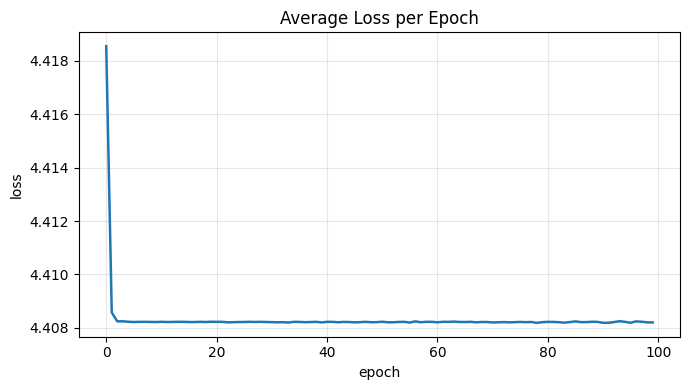

[saved] /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN/loss_per_epoch.png


In [11]:
# 1) Load metrics and training config
df = pd.read_csv(WORK / "metrics.csv")
with open(WORK / "config.yaml") as f:
    cfg = yaml.safe_load(f)
n_epochs = int(cfg.get("n_epochs", 100))

# 2) Pick the loss column (case-insensitive; fallback to last numeric column)
loss_col = next((c for c in df.columns if "loss" in c.lower()), None)
if loss_col is None:
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    assert len(num_cols) > 0, "No numeric columns found to use as loss."
    loss_col = num_cols[-1]

# 3) Assign an epoch index to each row by splitting rows as evenly as possible
N = len(df)
base = N // n_epochs
rem  = N % n_epochs
counts = np.full(n_epochs, base, dtype=int)
counts[:rem] += 1                             # distribute remainder to early epochs
epoch_idx = np.repeat(np.arange(n_epochs), counts)[:N]
df["_epoch_idx"] = epoch_idx

# 4) Aggregate and plot
df_ep = df.groupby("_epoch_idx", as_index=False)[loss_col].mean()

plt.figure(figsize=(7, 4))
plt.plot(df_ep["_epoch_idx"], df_ep[loss_col], linewidth=1.8)
plt.xlabel("epoch")
plt.ylabel(loss_col)
plt.title("Average Loss per Epoch")
plt.grid(True, alpha=0.3)
out_png = WORK / "loss_per_epoch.png"
plt.tight_layout()
plt.savefig(out_png, dpi=160)
plt.show()
print(f"[saved] {out_png}")